In [3]:
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go
import plotly.plotly as py
init_notebook_mode(connected=True)

def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))


In [10]:
import os
import datetime

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import folium
from google.colab import files
from google.colab import drive


drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.layers.advanced_activations import *
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D
from keras.layers.recurrent import LSTM, GRU
from keras import regularizers


Using TensorFlow backend.


In [0]:
data_path = os.path.join("/content/gdrive/My Drive", "Colab Notebooks/data/")
dataset_path = os.path.join(data_path, "data_hackathon_v04.csv")
dataset_time_path = os.path.join(data_path, "data_hackathon_time.csv")
saved_models = os.path.join("/content/gdrive/My Drive", "Colab Notebooks/saved_models")


In [13]:
os.listdir('/content/gdrive/My Drive/Colab Notebooks/data')

['data_hackathon_v04.csv',
 'data_hackathon_time.csv',
 'labeled_data.csv',
 'districts_time_data.csv',
 'time_demand_only.csv']

In [14]:
df = pd.read_csv(dataset_time_path, sep=',')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4433 entries, 0 to 4432
Data columns (total 2 columns):
time      4433 non-null object
demand    4433 non-null int64
dtypes: int64(1), object(1)
memory usage: 69.3+ KB


In [15]:
df.head()

,time,demand
0,2018-08-21 00:00:00,120
1,2018-08-21 01:00:00,126
2,2018-08-21 02:00:00,71
3,2018-08-21 03:00:00,64
4,2018-08-21 04:00:00,23


In [16]:
len(df[df.demand == 0])

0

In [0]:
dataset = df

In [18]:
df = pd.read_csv(dataset_path, sep="|")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117300 entries, 0 to 1117299
Data columns (total 12 columns):
ride_id               1117300 non-null object
created_at            1117300 non-null object
pickup_lat            1117300 non-null float64
pickup_lng            1117300 non-null float64
dropoff_lat           1117300 non-null float64
dropoff_lng           1117300 non-null float64
user_id               1117300 non-null object
driver_id             995791 non-null object
ride_distance         1117300 non-null float64
canceled_by_client    1117300 non-null int64
canceled_by_driver    1117300 non-null int64
ride_to_suburb        1117300 non-null int64
dtypes: float64(5), int64(3), object(4)
memory usage: 102.3+ MB


In [0]:
# df.created_at = df.created_at.apply(pd.to_datetime)


In [0]:
# df['time'] = df['created_at'].apply(lambda x: pd.Timestamp.round(x,'h'))


In [0]:
# dataset = pd.DataFrame(df['ride_id'].groupby(df.time).count())
# dataset = dataset.rename(columns={"ride_id": "demand"}, index=str)
# dataset.to_csv(dataset_time_path)
# dataset.info() 
#  

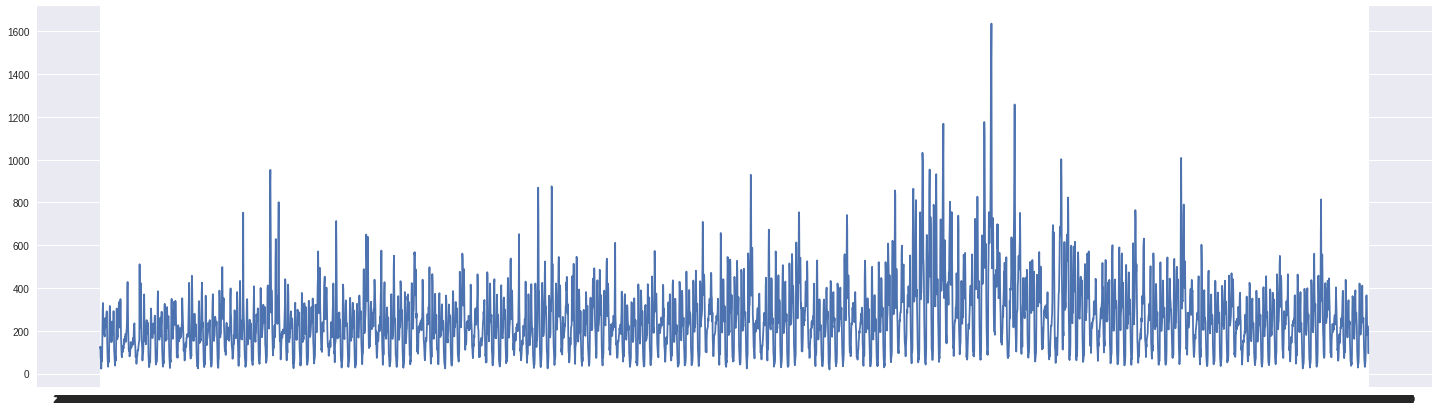

In [173]:

fig, ax = plt.subplots(figsize=(25, 7))
ax.plot_date(dataset.time, dataset.demand, '-')
# ax.xaxis_date()
# xfmt = mdates.DateFormatter('%Y-%m-%d-%H') #%H:%M:%S
# ax.xaxis.set_major_formatter(xfmt)

plt.show()

In [60]:
def plotly_df(df, title = '', plot_in=True):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    #iplot(fig, show_link=False)
    if plot_in:
      configure_plotly_browser_state()
      iplot(fig, show_link=False)
    else:    
      py.iplot(fig)

plotly_df(pd.DataFrame(df['ride_id'].groupby(df.time).count()), title = "Online users", plot_in=True)

In [19]:
dataset["demand"].median()

230.0

In [21]:
rand_seed = 100
np.random.seed(rand_seed)

def print_shapes(arrays, arr_names=[]):
    """
    Print shapes of numpy arrays or length of lists.
    :param list of np.ndarrays or lists arrays:
    :param list of str arr_names:
    """
    for i, array in enumerate(arrays):
        if len(arr_names) > i:
            arr_name = arr_names[i]
        else:
            arr_name = ""
        try:
            print(i + 1, arr_name, "shape =", array.shape, "Type =",
                  type(array), "Dtype =", array.dtype)
        except AttributeError:
            print(i + 1, arr_name, "shape =", len(array), "Type =",
                  type(array), "Elements type =", type(array[0]))
                 
def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b
  
def create_Xt_Yt(X, y, percentage=0.9):
    p = int(len(X) * percentage)
    X_train = X[0:p]
    Y_train = y[0:p]
     
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
 
    X_test = X[p:]
    Y_test = y[p:]
    return X_train, X_test, Y_train, Y_test


window = 168 # 720 # in houres
step = 1


X, Y = [], []
for i in range(0, len(dataset), step): 
    try:
        x_i = dataset.demand[i:i + window]
        y_i = dataset.demand[i + window]  
    except Exception as e:
        print(e)
        break
    X.append(x_i)
    Y.append(y_i)
    
X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y, 0.85)

4433


In [22]:
print_shapes([X_train, X_test, Y_train, Y_test])

1  shape = (3625, 168) Type = <class 'numpy.ndarray'> Dtype = int64
2  shape = (640, 168) Type = <class 'numpy.ndarray'> Dtype = int64
3  shape = (3625,) Type = <class 'numpy.ndarray'> Dtype = int64
4  shape = (640,) Type = <class 'numpy.ndarray'> Dtype = int64


In [27]:
week = 1

X, Y = [], []
for i in range(0, len(dataset), step): 
  try:
      x_i = list(dataset.demand[i: i + window])
      y_i = list(dataset.demand[i + window: i + window + week])  
      if len(x_i) != window or len(y_i) != week:
        continue
      
  except Exception as e:
      print(e)
      break
  X.append(x_i)
  Y.append(y_i)
  
X, Y = np.array(X), np.array(Y)

X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y, 0.80) 
print_shapes([X_train, X_test, Y_train, Y_test])


1  shape = (3412, 168) Type = <class 'numpy.ndarray'> Dtype = int64
2  shape = (853, 168) Type = <class 'numpy.ndarray'> Dtype = int64
3  shape = (3412, 1) Type = <class 'numpy.ndarray'> Dtype = int64
4  shape = (853, 1) Type = <class 'numpy.ndarray'> Dtype = int64


In [28]:
model = Sequential()
model.add(Dense(64, input_dim=window))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(week))
model.add(Activation('linear'))

model.compile(optimizer=Nadam(0.001), 
              loss = 'mse',
              metrics=['mae'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                10816     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 11,137
Trainable params: 11,009
Non-trainable params: 128
_________________________________________________________________


In [0]:
%%time

history = model.fit(X_train, Y_train, 
          nb_epoch = 250, 
          batch_size = 128, 
          verbose=2, 
          validation_data=(X_test, Y_test),
          shuffle=True,
          )

In [36]:
scores = model.evaluate(X_test, Y_test)
print("Test MAE =", scores[1])
print("Test MSE =", scores[0])

853/853 [==============================] - 0s 33us/step
Test MAE = 27.189086522754163
Test MSE = 1483.571973972835


In [35]:
list(history.history.keys())

['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error']

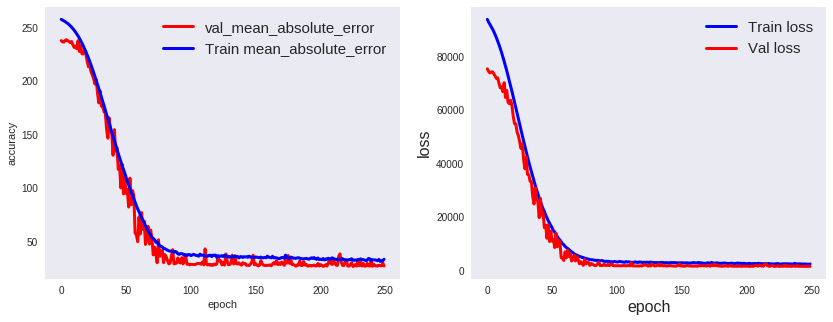

In [31]:
keys = list(history.history.keys())

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
ax[0].plot(history.history[keys[1]], label=keys[1],
        color="red", linewidth=3)
ax[0].plot(history.history[keys[3]], label="Train " + keys[3],
        color="blue", linewidth=3)
ax[0].set(xlabel="epoch", ylabel="accuracy")
ax[0].legend(loc=0, fontsize=15)
ax[0].grid()

ax[1].plot(history.history["loss"], label="Train loss", 
           color="blue", linewidth=3)
ax[1].plot(history.history["val_loss"], label="Val loss",
           color="red", linewidth=3)
ax[1].legend(loc=0, fontsize=15)
ax[1].set_xlabel("epoch", fontsize=16)
ax[1].set_ylabel("loss", fontsize=16)
ax[1].grid()

plt.show()

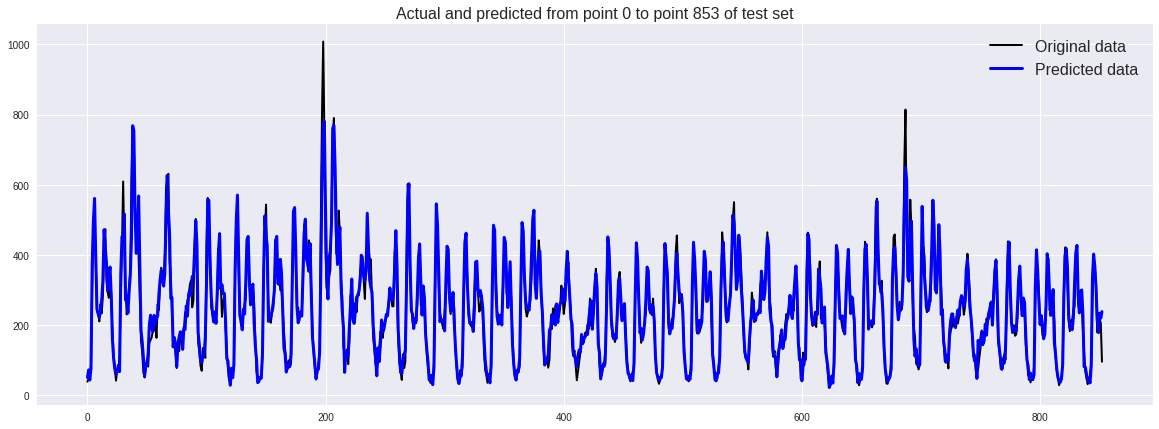

In [34]:

pred = model.predict(np.array(X_test))

FROM = 0
TO = FROM + len(pred)
original = Y_test
predicted = pred

fig, ax = plt.subplots(figsize=(20, 7))

ax.plot(original, color='black', label = 'Original data', linewidth=2, ls='-')
ax.plot(predicted, color='blue', label = 'Predicted data', linewidth=3, ls='-')
ax.legend(loc=0, fontsize=16)
ax.set_title('Actual and predicted from point %d to point %d of test set' % (FROM, TO), fontsize=16)
plt.show()

In [0]:


pred = model.predict(np.array(X_test))
print(pred.shape)

FROM = 0
TO = FROM + len(pred[-1, :])
print(TO)
original = Y_test[-1, :]
predicted = pred[-1, :]
print(predicted.shape)
print(original.shape)
fig, ax = plt.subplots(figsize=(20, 7))

ax.plot(original, color='black', label = 'Original data', linewidth=2, ls='-')
ax.plot(predicted, color='blue', label = 'Predicted data', linewidth=3, ls='-')
ax.legend(loc=0, fontsize=16)
ax.set_title('Actual and predicted from point %d to point %d of test set' % (FROM, TO), fontsize=16)
plt.show()